Ordinary differential equations: Conversion reaction
====================================================

<div class="alert alert-warning">
Note: Before you use pyABC to parametrize your ODE, please be aware of potential errors introduced by inadequately representing the data generation process, see also the "Measurement noise assessment" notebook. For deterministic models, there are often more efficient alternatives to ABC, check out for example our tool <a href="https://github.com/ICB-DCM/pyPESTO">pyPESTO</a>.
</div>

This example provides a model for the interconversion of two species 
($X_1$ and $X_2$) following first-order mass action kinetics with the 
parameters $\Theta_1$ and $\Theta_2$ respectively:


$$
    X_1 \rightarrow X_2, \quad\text{rate} = \Theta_1 \cdot [X_1]
$$

$$
    X_2 \rightarrow X_1, \quad\text{rate} = \Theta_2 \cdot [X_2]
$$

Measurement of $[X_2]$ is provided as $Y = [X_2]$.

We will show how to estimate $\Theta_1$ and $\Theta_2$ using pyABC.

In [1]:
# install if not done yet
!pip install pyabc --quiet

In [2]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon
from pyabc.visualization import plot_data_callback, plot_kde_2d

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")

Data
----

We use an artificial data set which consists of a vector of time points $t$
and a measurement vector $Y$. This data was created using the parameter 
values which are assigned to $\Theta_{\text{true}}$ and by adding normaly distributed 
measurement noise with variance $\sigma^2 = 0.015^2$. 

ODE model
---------

$$
    \begin{align*}
    \frac{dX_1}{dt} &= -\Theta_1 \cdot X_1 + \Theta_2 \cdot X_2\\
    \frac{dX_2}{dt} &= \Theta_1 \cdot X_1 - \Theta_2 \cdot X_2
    \end{align*}
$$

Define the true parameters

In [3]:
theta1_true, theta2_true = np.exp([-2.5, -2])

and the measurement data

In [4]:
measurement_data = np.array(
    [
        0.0244,
        0.0842,
        0.1208,
        0.1724,
        0.2315,
        0.2634,
        0.2831,
        0.3084,
        0.3079,
        0.3097,
        0.3324,
    ]
)

as well as the time points at whith to evaluate

In [5]:
measurement_times = np.arange(len(measurement_data))

and the initial conditions for $X_1$ and $X_2$

In [6]:
init = np.array([1, 0])

Define the ODE model

In [7]:
def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = -theta1 * x1 + theta2 * x2
    dx2 = theta1 * x1 - theta2 * x2
    return dx1, dx2


def model(pars):
    sol = sp.integrate.odeint(
        f, init, measurement_times, args=(pars["theta1"], pars["theta2"])
    )
    return {"X_2": sol[:, 1]}

Integration of the ODE model for the true parameter values

In [8]:
true_trajectory = model({"theta1": theta1_true, "theta2": theta2_true})["X_2"]

Let's visualize the results

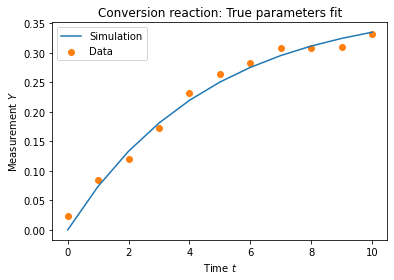

In [9]:
plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In [10]:
def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

Define the prior for $\Theta_1$ and $\Theta_2$

In [11]:
parameter_prior = Distribution(
    theta1=RV("uniform", 0, 1), theta2=RV("uniform", 0, 1)
)
parameter_prior.get_parameter_names()

['theta1', 'theta2']

In [12]:
abc = ABCSMC(
    models=model,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=50,
    transitions=LocalTransition(k_fraction=0.3),
    eps=MedianEpsilon(500, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 4 processes.


In [13]:
abc.new(db_path, {"X_2": measurement_data});

ABC.History INFO: Start <ABCSMC id=4, start_time=2021-11-18 17:40:36>


In [14]:
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

ABC INFO: t: 0, eps: 5.00000000e+02.
ABC INFO: Accepted: 50 / 53 = 9.4340e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 1.89305859e+00.
ABC INFO: Accepted: 50 / 164 = 3.0488e-01, ESS: 4.4195e+01.
ABC INFO: t: 2, eps: 9.64400074e-01.
ABC INFO: Accepted: 50 / 159 = 3.1447e-01, ESS: 3.7093e+01.
ABC INFO: t: 3, eps: 4.96905744e-01.
ABC INFO: Accepted: 50 / 329 = 1.5198e-01, ESS: 3.5372e+01.
ABC INFO: t: 4, eps: 2.94398923e-01.
ABC INFO: Accepted: 50 / 448 = 1.1161e-01, ESS: 4.4592e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=4, duration=0:00:03.032233, end_time=2021-11-18 17:40:39>


Visualization of the probability density functions for $\Theta_1$ and $\Theta_2$

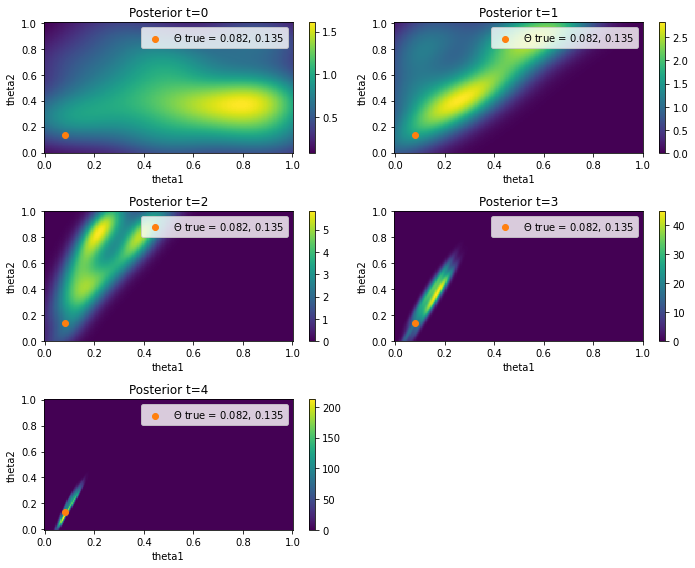

In [15]:
fig = plt.figure(figsize=(10, 8))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(3, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "theta1",
        "theta2",
        xmin=0,
        xmax=1,
        numx=200,
        ymin=0,
        ymax=1,
        numy=200,
        ax=ax,
    )
    ax.scatter(
        [theta1_true],
        [theta2_true],
        color="C1",
        label=r'$\Theta$ true = {:.3f}, {:.3f}'.format(
            theta1_true, theta2_true
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

We can also plot the simulated trajectories:

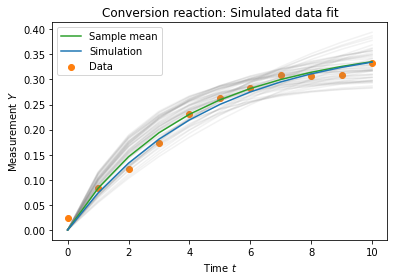

In [16]:
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['X_2'], color='grey', alpha=0.1)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['X_2'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: Simulated data fit')
plt.legend()
plt.show()